In [1]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

In [2]:
# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_layer_params(m, n, key, scale=1e-2):
  w_key, b_key = random.split(key)
  return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(sizes, key):
  keys = random.split(key, len(sizes))
  return [random_layer_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

## Input size = 2 (t,x)
layer_sizes = [2,1024,1024,1024,1]
step_size = 0.01
num_epochs = 1000
batch_size = 200
params = init_network_params(layer_sizes, random.PRNGKey(0))

In [3]:
from jax.scipy.special import logsumexp

def relu(x):
  return jnp.maximum(0, x)

def predict(params, image):
  # per-example predictions
  activations = image

  w, b = params[0]
  outputs = jnp.dot(w, activations) + b
  activations = relu(outputs)
  
  for w, b in params[1:-2]:
    outputs = jnp.dot(w, activations) + b
    activations = relu(outputs) + activations

  w, b = params[-2]
  outputs = jnp.dot(w, activations) + b
  activations = jnp.sin(outputs) + activations
  
  final_w, final_b = params[-1]
  yhat = jnp.dot(final_w, activations) + final_b
  return yhat

In [4]:
# This works on single examples
random_flattened_image = random.normal(random.PRNGKey(1), (2,))
preds = predict(params, random_flattened_image)
print(preds)
print(preds.shape)

[0.02207097]
(1,)


In [5]:
# Make a batched version of the `predict` function
batched_predict = vmap(predict, in_axes=(None, 0))

In [27]:
import numpy as np

results = np.load('tw_train.npz')
data = results['data']
stddev = results['std']
mean = results['mean']

def loss(params, inputs, targets):
  preds = batched_predict(params, inputs)
  return jnp.mean( (preds - targets) ** 2 )

def exact():
  # we discretize time in [0,70] with 20 points
  # space in [0,1] with 300 points
  NT = 20 
  NX = 300

  key = random.PRNGKey(0)

  x = jnp.sort(random.uniform(key,shape=(NX,)))

  key, newkey = random.split(key)
  t = jnp.sort(random.uniform(newkey,shape=(NT,))) * 70

  xx,tt=jnp.meshgrid(x,t)

  omega = 10
  c = 0.12/10
  x0 = 0.1

  # u = np.exp()
  u = jnp.exp(-1000.0*(xx-x0-c*tt)**2)*jnp.sin(omega*(xx-x0-c*tt))
  return ((xx.flatten()-mean[0])/stddev[0], \
          (tt.flatten()-mean[1])/stddev[1], \
           (u.flatten()-mean[2])/stddev[2] )

## This is the test set
x_e, t_e, u_e = exact()



In [7]:
print(x_e.shape)

(6000,)


In [8]:
import tensorflow as tf
import tensorflow_datasets as tfds

def get_train_batches():
  # as_supervised=True gives us the (image, label) as a tuple instead of a dict
  ds = tf.data.Dataset.from_tensor_slices((data[:,0:2], data[:,2].reshape(-1,1))).shuffle(data.shape[0])
  # You can build up an arbitrary tf.data input pipeline
  ds = ds.batch(batch_size).prefetch(1)
  # tfds.dataset_as_numpy converts the tf.data.Dataset into an iterable of NumPy arrays
  return tfds.as_numpy(ds)

@jit
def update(params, x, y):
  grads = grad(loss)(params, x, y)
  return [(w - step_size * dw, b - step_size * db)
          for (w, b), (dw, db) in zip(params, grads)]

2024-02-20 22:28:58.815755: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-20 22:28:58.815783: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-20 22:28:58.816493: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-20 22:28:59.392445: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/juandiego/miniconda3/envs/jaxenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebo

In [9]:
import time

for epoch in range(num_epochs):
  start_time = time.time()
  for x, y in get_train_batches():
    # print(x.shape, y.shape)
    params = update(params, x, y)
  epoch_time = time.time() - start_time

  train_loss = loss(params, data[:,0:2], data[:,2].reshape(-1,1))
  test_loss = loss(params, jnp.hstack((x_e.reshape(-1,1), t_e.reshape(-1,1))), u_e.reshape(-1,1))
  print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
  print("Training set error {}".format(train_loss))
  print("Test set error {}".format(test_loss))

Epoch 0 in 4.70 sec
Training set error 0.9999648332595825
Test set error 1.04084312915802
Epoch 1 in 0.02 sec
Training set error 0.9998135566711426
Test set error 1.040726661682129
Epoch 2 in 0.02 sec
Training set error 0.9996935129165649
Test set error 1.040635347366333
Epoch 3 in 0.02 sec
Training set error 0.9995753765106201
Test set error 1.0405607223510742
Epoch 4 in 0.02 sec
Training set error 0.9995063543319702
Test set error 1.0404942035675049
Epoch 5 in 0.02 sec
Training set error 0.9994264245033264
Test set error 1.0404465198516846
Epoch 6 in 0.02 sec
Training set error 0.9993658661842346
Test set error 1.04038667678833
Epoch 7 in 0.02 sec
Training set error 0.9993090629577637
Test set error 1.04036545753479
Epoch 8 in 0.02 sec
Training set error 0.9992535710334778
Test set error 1.0403162240982056
Epoch 9 in 0.02 sec
Training set error 0.999221682548523
Test set error 1.0403136014938354
Epoch 10 in 0.02 sec
Training set error 0.9991876482963562
Test set error 1.0402952432632

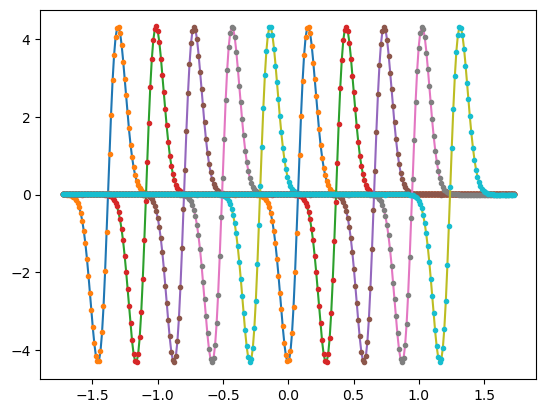

In [15]:
from matplotlib import pyplot as plt

yplot = batched_predict(params,data[:,0:2])

plt.close('all')
plt.figure()

for i in range(0,6000,600):
    plt.plot(data[i:i+300,0], data[i:i+300,2])
    plt.plot(data[i:i+300,0],yplot[i:i+300],ls='None',marker='.')

plt.show()



In [28]:
print(x_e)
print(t_e)

[-1.725433  -1.7221467 -1.7218126 ...  1.7150489  1.7174824  1.7268701]
[-1.5865817 -1.5865817 -1.5865817 ...  1.7423564  1.7423564  1.7423564]


(6000, 2)


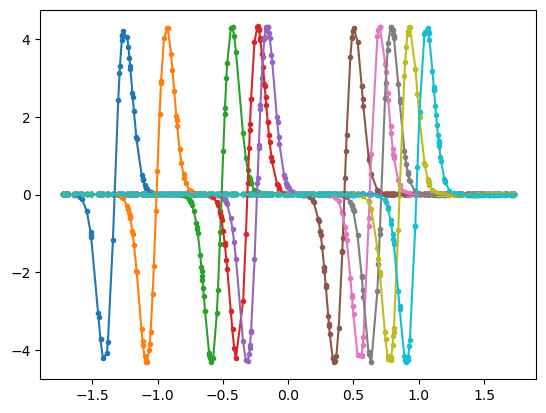

In [31]:
xplot = jnp.hstack( (x_e.reshape(-1,1), t_e.reshape(-1,1)) )

print(xplot.shape)
yplot = batched_predict(params,xplot)

plt.figure()

for i in range(0,6000,600):
    plt.plot(x_e[i:i+300], u_e[i:i+300])
    plt.scatter(x_e[i:i+300],yplot[i:i+300],marker='.',)

plt.show()